### Filter the Reichart adata provided in the supplemental material

The adata is very large, but the majority of the non-diseased samples are not from this study, but other studies such as the Teichman ones. Therefore, we should filter this adata to a smaller one that just includes the 6 new, non-diseased samples.

#### Reichart et al. 2022 (Seidman Lab)

1. Technology: 10x 3' v3
2. Cell vs. nuclei: Nuclei only
3. Regions: 'LV': 219149, 'RV': 63223

Characterized 880,000 nuclei from 18 control and 61 failing, nonischemic human hearts with pathogenic variants in DCM and ACM genes or idiopathic disease. However, 12 of the controls are from the Litvinukova study, so there are only 6 additional samples from this dataset.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
from collections import Counter
import re
import gc
import scanpy.external as sce

In [2]:
def age_convertor(input_string):
    # Split the input string by '-'
    parts = input_string.split('-')

    # Convert parts to integers
    numbers = [int(part) for part in parts]

    # Calculate the average
    average_value = sum(numbers) / len(numbers)

    return average_value

In [3]:
def convert_decade(decade_str):
    # Extract decade number using regular expression
    decade_number = re.search(r'\b(\w+)\b', decade_str).group(1)
    
    # Convert decade number to the desired format
    if decade_number == 'third':
        return '30-39'
    elif decade_number == 'fifth':
        return '50-59'
    elif decade_number == 'sixth':
        return '60-69'
    elif decade_number == 'seventh':
        return '70-79'
    else:
        return None

In [4]:
def preprocess_adata(adata, donor_key, leiden_resolution):
    '''
    Performs: 
    1. library size normalization and log scaling
    2. identification of top 2K highly variable genes, 
    3. Principal component analysis
    4. Harmony integration
    5. Neighbor neighbors computation in Harmony integration embedding
    6. Leiden clustering 
    
    Parameters:
    adata (AnnData): adata object before preprocessing
    donor_key: the column in adata.obs that corresponds to the donor information (should be 'donor_id')
    leiden_resolution: resolution for leiden clustering, higher means more clusters will be detected

    Returns:
    adata: Postprocessed adata
    '''
    # Normalizing to median total counts
    sc.pp.normalize_total(adata)
    # Logarithmize the data
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key=donor_key)
    sc.tl.pca(adata)
    sce.pp.harmony_integrate(adata, donor_key)
    sc.pp.neighbors(adata, use_rep = "X_pca_harmony")
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=donor_key, size=2)
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution = 0.5)
    return(adata)

Load in the Reichart adata

In [5]:
%%time
# load in the full adata -- takes a while since it's quite large
adata = sc.read_h5ad("Reichart_et_al_2022.h5ad")
# filter to only those that are "normal"
adata = adata[adata.obs.disease == "normal", :]
adata

CPU times: user 1min 14s, sys: 25.6 s, total: 1min 40s
Wall time: 1min 40s


View of AnnData object with n_obs × n_vars = 282372 × 33145
    obs: 'Sample', 'donor_id', 'Region_x', 'Primary.Genetic.Diagnosis', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'scrublet_score_z', 'scrublet_score_log', 'solo_score', 'cell_states', 'Assigned', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'sex_ontology_term_id', 'assay_ontology_term_id', 'organism_ontology_term_id', 'is_primary_data', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'cell_states_colors', 'cell_type_ontology_term_id_colors', 'citation', 'leiden', 'neighbors', 'pca', 'schema_reference', 'schema_version', 'title', 'umap'
    obsm: 'X_pca', 'X_umap'

In [6]:
adata.obs

,Sample,donor_id,Region_x,Primary.Genetic.Diagnosis,n_genes,n_counts,percent_mito,percent_ribo,scrublet_score_z,scrublet_score_log,...,tissue_type,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid
2428,BS_H25_S00_premrna,H3,LV,control,649,907,0.004410,0.002205,0.017023,0.129609,...,tissue,mural cell,10x 3' v3,normal,Homo sapiens,male,interventricular septum,Asian,sixth decade human stage,hSzSW6M}4h
2429,BS_H25_S00_premrna,H3,LV,control,1479,2659,0.000376,0.002256,0.033552,0.022799,...,tissue,cardiac muscle cell,10x 3' v3,normal,Homo sapiens,male,interventricular septum,Asian,sixth decade human stage,qvlMZ4WH*)
2430,BS_H25_S00_premrna,H3,LV,control,716,1157,0.000864,0.000864,0.043906,0.000817,...,tissue,cardiac muscle cell,10x 3' v3,normal,Homo sapiens,male,interventricular septum,Asian,sixth decade human stage,`R#(|sdmUn
2431,BS_H25_S00_premrna,H3,LV,control,753,1055,0.007583,0.000000,0.094017,0.066094,...,tissue,endothelial cell,10x 3' v3,normal,Homo sapiens,male,interventricular septum,Asian,sixth decade human stage,v!t5LK4zym
2432,BS_H25_S00_premrna,H3,LV,control,429,603,0.001658,0.001658,0.021382,0.021382,...,tissue,mural cell,10x 3' v3,normal,Homo sapiens,male,interventricular septum,Asian,sixth decade human stage,9Xkimlyf<G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868751,HCAHeart7888928_premrna,D7,RV,control,1200,1871,0.001069,0.002672,0.013731,0.004695,...,tissue,fibroblast of cardiac tissue,10x 3' v2,normal,Homo sapiens,male,heart right ventricle,European,seventh decade human stage,f5chT`=Rl@
868752,HCAHeart7888928_premrna,D7,RV,control,2036,4672,0.001284,0.001498,0.048815,0.008781,...,tissue,cardiac muscle cell,10x 3' v2,normal,Homo sapiens,male,heart right ventricle,European,seventh decade human stage,Ph$4$X8&KM
868753,HCAHeart7888928_premrna,D7,RV,control,3419,10796,0.000556,0.001112,0.060842,0.046372,...,tissue,cardiac muscle cell,10x 3' v2,normal,Homo sapiens,male,heart right ventricle,European,seventh decade human stage,3d3;+zfMje
868754,HCAHeart7888928_premrna,D7,RV,control,1734,4762,0.000420,0.001470,0.030558,0.001951,...,tissue,cardiac muscle cell,10x 3' v2,normal,Homo sapiens,male,heart right ventricle,European,seventh decade human stage,;#7$VzZfGk


In [7]:
%%time
# make the count matrix the raw counts
adata = adata.raw.to_adata()
# confirm that these are the raw counts
adata.X.sum(axis = 1)

CPU times: user 686 ms, sys: 18.1 s, total: 18.8 s
Wall time: 19.1 s


matrix([[  905.],
        [ 2653.],
        [ 1156.],
        ...,
        [10781.],
        [ 4756.],
        [ 1057.]], dtype=float32)

In [8]:
# examine the regions that were studied
Counter(adata.obs.Region_x)

Counter({'LV': 219149, 'RV': 63223})

In [9]:
# further filter only to LV 
adata = adata[adata.obs.Region_x == "LV", :].copy()

In [10]:
# only the BO samples are unique to Reichart et al. (other controls were taken from other studies)
Reichart_donor_names = adata.obs['Sample'].str.startswith('BO')
adata = adata[Reichart_donor_names, :].copy()
adata

AnnData object with n_obs × n_vars = 57241 × 33145
    obs: 'Sample', 'donor_id', 'Region_x', 'Primary.Genetic.Diagnosis', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'scrublet_score_z', 'scrublet_score_log', 'solo_score', 'cell_states', 'Assigned', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'sex_ontology_term_id', 'assay_ontology_term_id', 'organism_ontology_term_id', 'is_primary_data', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'cell_states_colors', 'cell_type_ontology_term_id_colors', 'citation', 'leiden', 'neighbors', 'pca', 'schema_reference', 'schema_version', 'title', 'umap'
    obsm: 'X_pca', 'X_umap'

In [11]:
# add Reichart to make the donor id names unique
adata.obs.donor_id = adata.obs.donor_id.astype('str')
adata.obs.donor_id = "Reichart" + adata.obs.donor_id

Convert the age range to the midpoint integer

In [12]:
# convert string from 'seventh decade human stage' to 70-79
adata.obs.development_stage = adata.obs.development_stage.apply(convert_decade)
# then, convert 70-79 to 75
adata.obs.development_stage = adata.obs.development_stage.apply(lambda x: age_convertor(x))

In [13]:
# extract the relevant metadata
metadata = adata.obs[['cell_type', 'donor_id', 'Region_x', 'sex', 'development_stage']]

# for later consistency, change the column names
metadata = metadata.rename(columns={'assay': 'technology', 'Region_x': 'region', 'development_stage': 'age'})

# add additional metadata column
metadata['technology'] = '3prime-v3' 
metadata['cell_or_nuclei'] = 'Nuclei'
metadata['study'] = 'Reichart 2022'

# add back metadata to adata
adata.obs = metadata
adata.obs.head()

,cell_type,donor_id,region,sex,age,technology,cell_or_nuclei,study
221966,endothelial cell,ReichartH53,LV,male,74.5,3prime-v3,Nuclei,Reichart 2022
221967,fibroblast of cardiac tissue,ReichartH53,LV,male,74.5,3prime-v3,Nuclei,Reichart 2022
221968,mural cell,ReichartH53,LV,male,74.5,3prime-v3,Nuclei,Reichart 2022
221969,cardiac muscle cell,ReichartH53,LV,male,74.5,3prime-v3,Nuclei,Reichart 2022
221970,endothelial cell,ReichartH53,LV,male,74.5,3prime-v3,Nuclei,Reichart 2022


### Perform standard preprocessing

In [14]:
# store the raw counts
adata.layers["counts"] = adata.X.copy()

In [15]:
# make the gene symbols as adata var names, not the ensembl_id
adata.var['ensembl_id'] = adata.var_names
adata.var_names = adata.var['feature_name'].astype(str)
adata.var = adata.var.drop(columns = ['feature_name'])

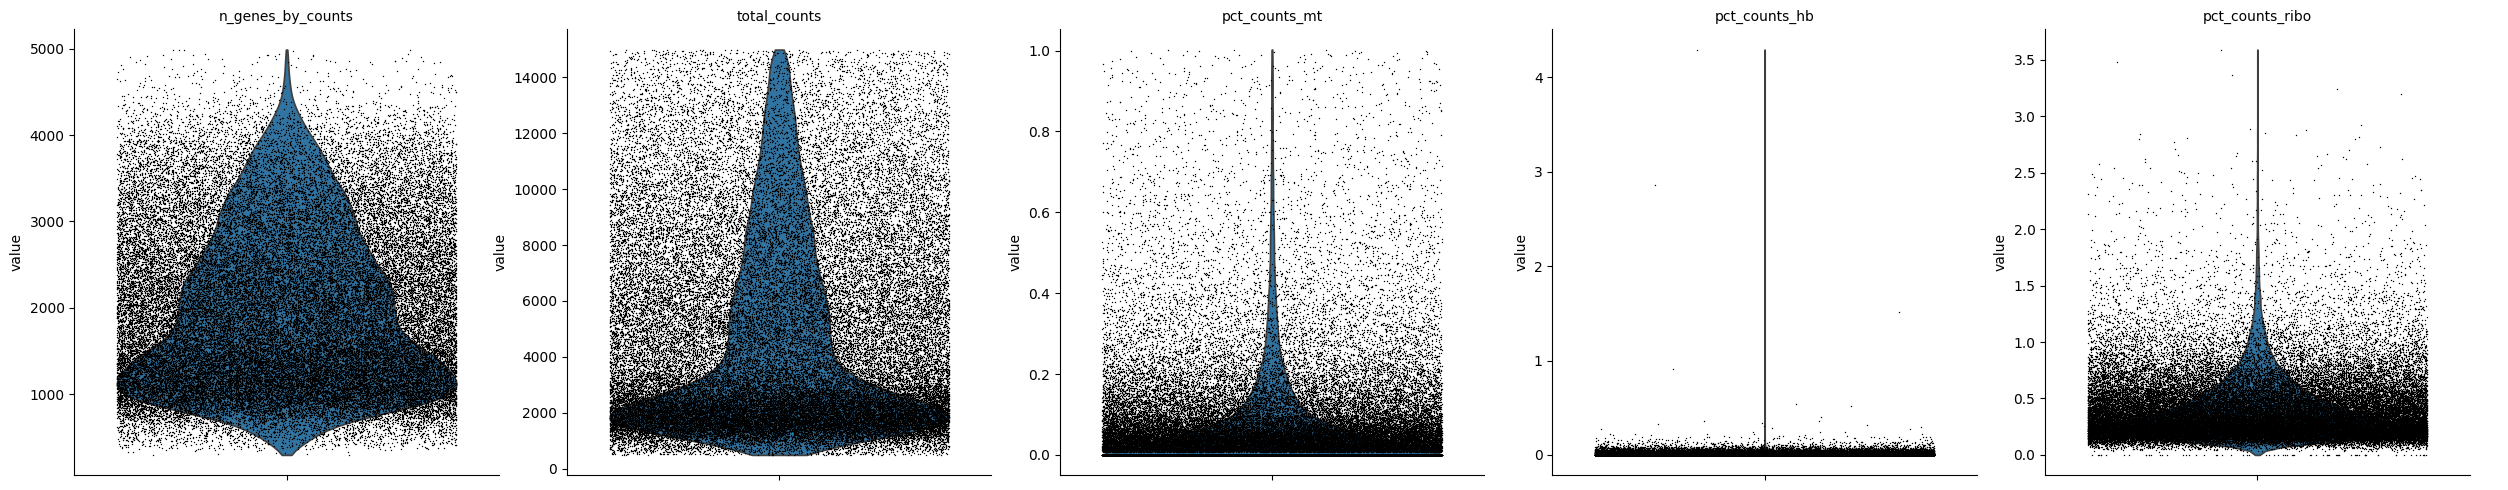

Filtered out 0 cells
CPU times: user 24 s, sys: 27.2 s, total: 51.3 s
Wall time: 8.68 s


In [16]:
%%time 

adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_hb", "pct_counts_ribo"], 
             jitter=0.4,multi_panel=True,)

# filter the cells out that are above the specified thresholds for mitochondrial, ribosomal, and hemoglobin reads
mito_threshold = 5.0
ribo_threshold = 5.0
hb_threshold = 5.0 

adata_size_before = adata.shape[0]

adata = ( adata[(adata.obs.pct_counts_mt <= mito_threshold) &
                (adata.obs.pct_counts_ribo <= ribo_threshold) &
                (adata.obs.pct_counts_hb <= hb_threshold), :].copy()
        )

adata_size_after = adata.shape[0]
num_filtered = adata_size_before - adata_size_after
print(f"Filtered out {num_filtered} cells")

In [17]:
%%time
donor_key = "donor_id"
# predict the doublets with scrublet
sc.pp.scrublet(adata, batch_key = donor_key)
num_doublets = adata[adata.obs.predicted_doublet == True].shape[0]
# filter out the doublets
adata = adata[adata.obs.predicted_doublet == False, :].copy()
print(f"Filtered out {num_doublets} likely doublets")

Filtered out 1369 likely doublets
CPU times: user 14min 2s, sys: 14min 11s, total: 28min 13s
Wall time: 8min 30s


2024-11-23 02:49:17,433 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-23 02:49:21,372 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-23 02:49:23,380 - harmonypy - INFO - Iteration 1 of 10
2024-11-23 02:50:03,786 - harmonypy - INFO - Iteration 2 of 10
2024-11-23 02:50:50,071 - harmonypy - INFO - Iteration 3 of 10
2024-11-23 02:51:27,336 - harmonypy - INFO - Converged after 3 iterations


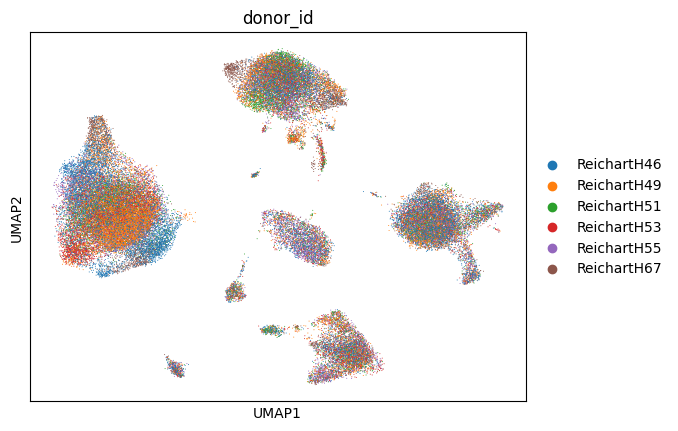

In [18]:
LEIDEN_RES = 0.5
adata = preprocess_adata(adata = adata, 
                         donor_key = "donor_id",
                         leiden_resolution = LEIDEN_RES)

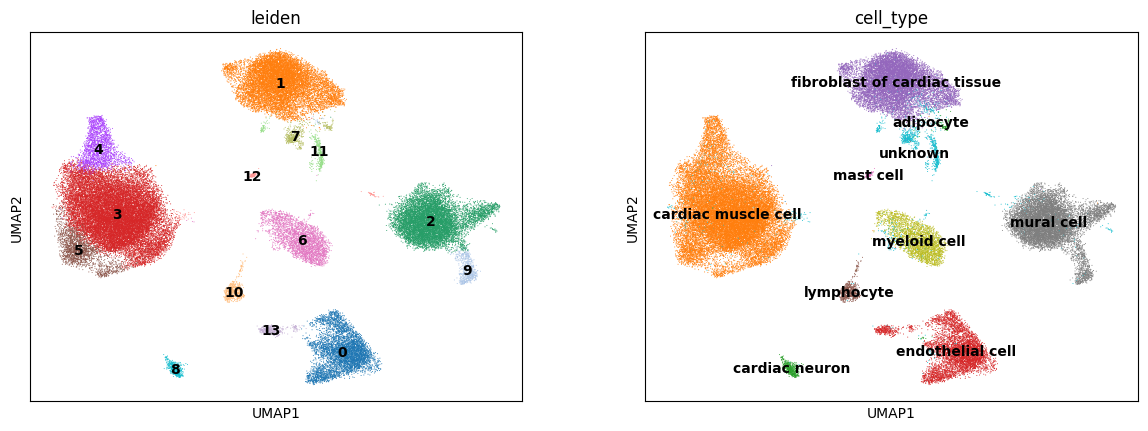

In [19]:
sc.pl.umap(adata, color=["leiden", "cell_type"], size=2, legend_loc = "on data")

In [20]:
set(adata.obs.cell_type)

{'adipocyte',
 'cardiac muscle cell',
 'cardiac neuron',
 'endothelial cell',
 'fibroblast of cardiac tissue',
 'lymphocyte',
 'mast cell',
 'mural cell',
 'myeloid cell',
 'unknown'}

In [21]:
# drop the unknown category
adata = adata[adata.obs.cell_type != "unknown", :].copy()

In [22]:
adata.obs["consistent_cell_type"] = adata.obs["cell_type"].map(
    {
        "adipocyte": "Adipocyte",
        "cardiac muscle cell": "Cardiomyocyte",
        "cardiac neuron": "Neuronal",
        "endothelial cell": "Endothelial",
        "fibroblast of cardiac tissue": "Fibroblast",
        "lymphocyte": "Lymphoid",
        "mast cell": "Mast",
        "mural cell": "Pericyte",
        "myeloid cell": "Myeloid",
    }
)

In [23]:
set(adata.obs.consistent_cell_type)

{'Adipocyte',
 'Cardiomyocyte',
 'Endothelial',
 'Fibroblast',
 'Lymphoid',
 'Mast',
 'Myeloid',
 'Neuronal',
 'Pericyte'}

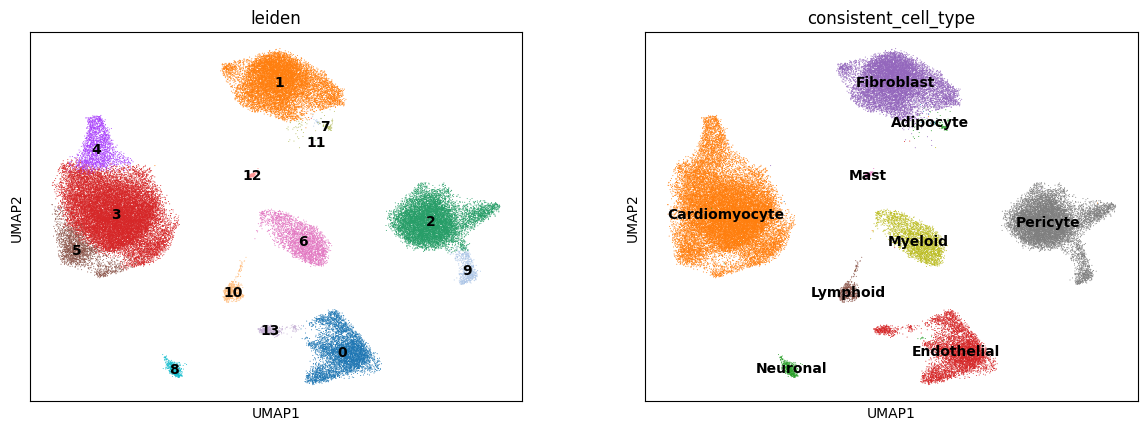

In [24]:
sc.pl.umap(adata, color=["leiden", "consistent_cell_type"], size=2, legend_loc = "on data")

In [25]:
adata.write("processed_Reichart_ND.h5ad")